In [1]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix, f1_score, classification_report, ConfusionMatrixDisplay
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt

In [21]:
# Function to plot and save ROC curve
def plot_roc_curve(y_test, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - ' + model_name)
    plt.legend(loc="lower right")
    plt.savefig(f'../figures/{model_name}_roc_curve.png'.replace(' ', '_'))
    plt.close()

# Function to plot and save Precision-Recall curve
def plot_precision_recall_curve(y_test, y_pred_prob, model_name):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - ' + model_name)
    plt.legend(loc="lower left")
    plt.savefig(f'../figures/{model_name}_precision_recall_curve.png'.replace(' ', '_'))
    plt.close()

In [4]:
df_train['DIED']

0         0
1         0
2         0
3         0
4         0
         ..
817594    0
817595    0
817596    0
817597    0
817598    0
Name: DIED, Length: 817599, dtype: int64

In [5]:
x_train = df_train.drop(columns = ['DIED'])
y_train = df_train['DIED']

x_test = df_test.drop(columns = ['DIED'])
y_test = df_test['DIED']


# Logistic Regression

In [6]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=1, max_iter=300)
lr_model_res = lr_clf.fit(x_train, y_train)
lr_y_pred = lr_model_res.predict(x_test)
lr_y_pred_prob = lr_model_res.predict_proba(x_test)[:, 1]

# Evaluation
plot_roc_curve(y_test, lr_y_pred_prob, 'Logistic Regression')
plot_precision_recall_curve(y_test, lr_y_pred_prob, 'Logistic Regression')


In [8]:
lr_clf.score(x_test, y_test)

0.9287377690802349

In [9]:
print(classification_report(y_test, lr_y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96    189834
           1       0.00      0.00      0.00     14566

    accuracy                           0.93    204400
   macro avg       0.46      0.50      0.48    204400
weighted avg       0.86      0.93      0.89    204400



c:\Users\Azadeh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Azadeh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Azadeh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
lr_clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 300,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 1,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Optimize Logistic Regression Model using Bayesian Optimization

In [25]:
def objective_function(C, penalty):
    C = 10 ** C  # Convert C from log scale
    penalty = 'l1' if penalty < 0.5 else 'l2'  # Map to 'l1' or 'l2'
    
    # Create logistic regression model with specified parameters
    model = LogisticRegression(C=C, penalty=penalty, solver='liblinear', random_state=42)
    
    # Calculate cross-validated accuracy
    cv_accuracy = np.mean(cross_val_score(model, x_train, y_train, cv=5))
    
    return cv_accuracy

# Define parameter space
pbounds = {'C': (-3, 3), 'penalty': (0, 1)}  # Log scale for C, binary for penalty choice

# Run Bayesian optimization
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(init_points=5, n_iter=15)

# Print best parameters found
best_params = optimizer.max['params']
print("Best Parameters:", best_params)

|   iter    |  target   |     C     |  penalty  |
-------------------------------------------------
| 1         | 0.9278    | -0.7528   | 0.9507    |
| 2         | 0.9278    | 1.392     | 0.5987    |
| 3         | 0.9492    | -2.064    | 0.156     |
| 4         | 0.9278    | -2.651    | 0.8662    |
| 5         | 0.9278    | 0.6067    | 0.7081    |
| 6         | 0.9491    | -2.018    | 0.1643    |
| 7         | 0.9491    | 3.0       | 0.0       |
| 8         | 0.9278    | 3.0       | 0.8541    |
| 9         | 0.9491    | 2.475     | 0.0       |
| 10        | 0.9491    | -1.27     | 0.0       |
| 11        | 0.9481    | -3.0      | 0.0       |
| 12        | 0.9491    | -0.4174   | 0.0       |
| 13        | 0.9491    | 0.165     | 0.0       |
| 14        | 0.9491    | -1.788    | 0.0       |
| 15        | 0.9491    | 1.9       | 0.0       |
| 16        | 0.9491    | 0.8876    | 0.0       |
| 17        | 0.9491    | -2.558    | 0.0       |
| 18        | 0.9491    | 1.36      | 0.007099  |


In [26]:
# Train logistic regression model with best parameters
best_C = 10 ** best_params['C']  # Convert C from log scale
best_penalty = 'l1' if best_params['penalty'] < 0.5 else 'l2'  # Map to 'l1' or 'l2'

best_model = LogisticRegression(C=best_C, penalty=best_penalty, solver='liblinear', random_state=42)
best_model.fit(x_train, y_train)

# Evaluate performance
y_pred = best_model.predict(x_train)
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9492000357143294


In [27]:
y_test_predicted = best_model.predict(x_test)
F1 = f1_score(y_train,y_pred)
# best_model.predict_proba()
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    758560
           1       0.71      0.50      0.59     59039

    accuracy                           0.95    817599
   macro avg       0.84      0.74      0.78    817599
weighted avg       0.94      0.95      0.95    817599



* Precision: out of people we thought die -> 71% actually died
* Recall: out of all people who actually died, 50% of them we got 1 

In [28]:
y_prob = best_model.predict_proba(x_test)[:, 1]

# Calculate AUC
auc_score = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc_score)

AUC Score: 0.9631480671093301


In [29]:
plot_roc_curve(y_test, y_prob, 'Logistic Regression_Best')
plot_precision_recall_curve(y_test, y_prob, 'Logistic Regression_Best')

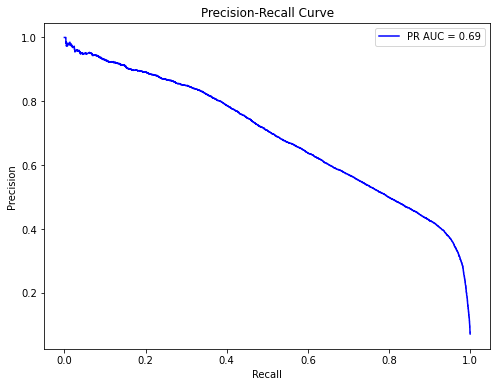

In [15]:
import matplotlib.pyplot as plt

 # Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=300, random_state=1, n_jobs=-1)
rf_model_res = rf_clf.fit(x_train, y_train)
rf_y_pred = rf_model_res.predict(x_test)
rf_y_pred_prob = rf_model_res.predict_proba(x_test)[:, 1]
rf_ac = accuracy_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred, average='weighted')
rf_cm = confusion_matrix(y_test, rf_y_pred)

print('Random Forest: Accuracy=%.3f' % (rf_ac))

print('Random Forest: f1-score=%.3f' % (rf_f1))

# Evaluation
plot_roc_curve(y_test, rf_y_pred_prob, 'Random Forest')
plot_precision_recall_curve(y_test, rf_y_pred_prob, 'Random Forest')


Random Forest: Accuracy=0.945
Random Forest: f1-score=0.943


In [13]:
print(classification_report(y_test,rf_y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    189834
           1       0.64      0.53      0.58     14566

    accuracy                           0.94    204400
   macro avg       0.80      0.76      0.78    204400
weighted avg       0.94      0.94      0.94    204400



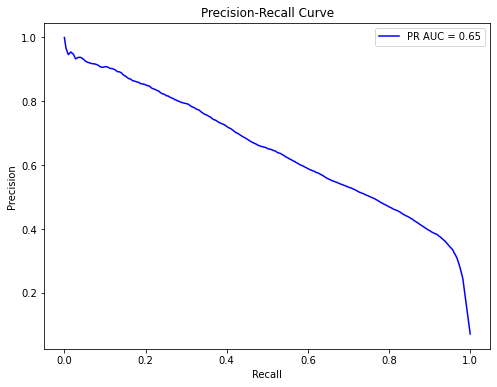

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, rf_y_pred_prob)
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

In [11]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# SVM Classifier
# Feature scaling
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# SVM with linear kernel
svm_clf = SVC(probability=True, kernel='linear', random_state=1)
svm_model_res = svm_clf.fit(x_train_scaled, y_train)
svm_y_pred = svm_model_res.predict(x_test_scaled)
svm_y_pred_prob = svm_model_res.predict_proba(x_test_scaled)
svm_probs = svm_y_pred_prob[:, 1]

# Evaluation
plot_roc_curve(y_test, svm_probs, 'SVM')
plot_precision_recall_curve(y_test, svm_probs, 'SVM')

# Evaluation metrics
svm_ac = accuracy_score(y_test, svm_y_pred)
svm_f1 = f1_score(y_test, svm_y_pred, average='weighted')
svm_cm = confusion_matrix(y_test, svm_y_pred)

print('SVM: Accuracy=%.3f' % (svm_ac))
print('SVM: f1-score=%.3f' % (svm_f1))
print("SVM Confusion Matrix:\n", svm_cm)
print("SVM Classification Report:\n", classification_report(y_test, svm_y_pred))

In [ ]:
# Evaluation
plot_roc_curve(y_test, svm_y_pred_prob, 'SVM')
plot_precision_recall_curve(y_test, svm_y_pred_prob, 'SVM')

In [24]:
from sklearn.linear_model import SGDClassifier

# SGDClassifier as linear SVM
sgd_clf = SGDClassifier(loss='hinge', random_state=1)
sgd_model_res = sgd_clf.fit(x_train, y_train)
sgd_y_pred = sgd_model_res.predict(x_test)
sgd_y_pred_prob = sgd_model_res.decision_function(x_test)  # For ROC curve
sgd_probs = (sgd_y_pred_prob - sgd_y_pred_prob.min()) / (sgd_y_pred_prob.max() - sgd_y_pred_prob.min())

# Evaluation
plot_roc_curve(y_test, sgd_probs, 'SGDClassifier')
plot_precision_recall_curve(y_test, sgd_probs, 'SGDClassifier')

# Evaluation metrics
sgd_ac = accuracy_score(y_test, sgd_y_pred)
sgd_f1 = f1_score(y_test, sgd_y_pred, average='weighted')
sgd_cm = confusion_matrix(y_test, sgd_y_pred)

print('SGDClassifier: Accuracy=%.3f' % (sgd_ac))
print('SGDClassifier: f1-score=%.3f' % (sgd_f1))
print("SGDClassifier Confusion Matrix:\n", sgd_cm)
print("SGDClassifier Classification Report:\n", classification_report(y_test, sgd_y_pred))

SGDClassifier: Accuracy=0.073
SGDClassifier: f1-score=0.013
SGDClassifier Confusion Matrix:
 [[   319 189515]
 [    10  14556]]
SGDClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.00      0.00    189834
           1       0.07      1.00      0.13     14566

    accuracy                           0.07    204400
   macro avg       0.52      0.50      0.07    204400
weighted avg       0.91      0.07      0.01    204400



In [15]:
from xgboost import XGBClassifier

# XGBoost Classifier
xgb_clf = XGBClassifier(n_estimators=300, random_state=1, use_label_encoder=False, eval_metric='logloss')
xgb_model_res = xgb_clf.fit(x_train, y_train)
xgb_y_pred = xgb_model_res.predict(x_test)
xgb_y_pred_prob = xgb_model_res.predict_proba(x_test)
xgb_probs = xgb_y_pred_prob[:, 1]

# Evaluation
xgb_ac = accuracy_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred, average='weighted')
xgb_cm = confusion_matrix(y_test, xgb_y_pred)

print('XGBoost: Accuracy=%.3f' % (xgb_ac))
print('XGBoost: f1-score=%.3f' % (xgb_f1))
print("XGBoost Confusion Matrix:\n", xgb_cm)
print("XGBoost Classification Report:\n", classification_report(y_test, xgb_y_pred))


c:\Users\Azadeh\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBoost: Accuracy=0.951
XGBoost: f1-score=0.947
XGBoost Confusion Matrix:
 [[186796   3038]
 [  7068   7498]]
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97    189834
           1       0.71      0.51      0.60     14566

    accuracy                           0.95    204400
   macro avg       0.84      0.75      0.79    204400
weighted avg       0.95      0.95      0.95    204400



In [20]:
# Evaluation
plot_roc_curve(y_test, xgb_y_pred, 'XGBoost')
plot_precision_recall_curve(y_test, xgb_y_pred, 'XGBoost')

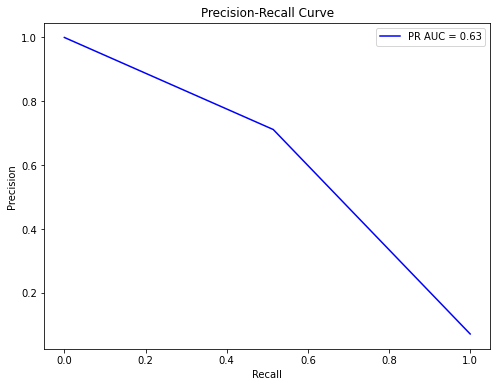

In [17]:
precision, recall, thresholds = precision_recall_curve(y_test, xgb_y_pred)
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

Random Forest seems to be a better model.